In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [10]:
# Load CIFAR-10 dataset and preprocess the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [11]:
# Define the DenseNet model for fine-tuning
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']       

In [12]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,          # Randomly rotate images by 15 degrees
    width_shift_range=0.1,      # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,     # Randomly shift images vertically by 10% of the height
    horizontal_flip=True,       # Randomly flip images horizontally
    zoom_range=0.1              # Randomly zoom images by 10%
)



In [13]:
# Train the model using the validation set for monitoring
batch_size = 300
epochs = 100
# history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1)

# Calculate the number of steps per epoch
steps_per_epoch = len(x_train) // batch_size

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/100
150/150 [==============================] - 32s 131ms/step - loss: 2.4742 - accuracy: 0.1453 - val_loss: 2.1520 - val_accuracy: 0.3166
Epoch 2/100
150/150 [==============================] - 19s 128ms/step - loss: 1.9367 - accuracy: 0.3066 - val_loss: 1.5701 - val_accuracy: 0.5238
Epoch 3/100
150/150 [==============================] - 19s 124ms/step - loss: 1.4654 - accuracy: 0.4889 - val_loss: 1.0810 - val_accuracy: 0.6674
Epoch 4/100
150/150 [==============================] - 18s 121ms/step - loss: 1.1706 - accuracy: 0.6120 - val_loss: 0.9117 - val_accuracy: 0.7058
Epoch 5/100
150/150 [==============================] - 19s 126ms/step - loss: 0.9730 - accuracy: 0.6911 - val_loss: 0.7558 - val_accuracy: 0.7604
Epoch 6/100
150/150 [==============================] - 19s 124ms/step - loss: 0.8440 - accuracy: 0.7331 - val_loss: 0.6617 - val_accuracy: 0.7902
Epoch 7/100
150/150 [==============================] - 19s 126ms/step - loss: 0.7645 - accuracy: 0.7655 - val_loss: 0.6633 -

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

34/34 [==============================] - 1s 26ms/step - loss: 0.5694 - accuracy: 0.8818
Test Loss: 0.5694164633750916
Test Accuracy: 0.8817999958992004


In [15]:
# plotting helper function
def plothist(hist):
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

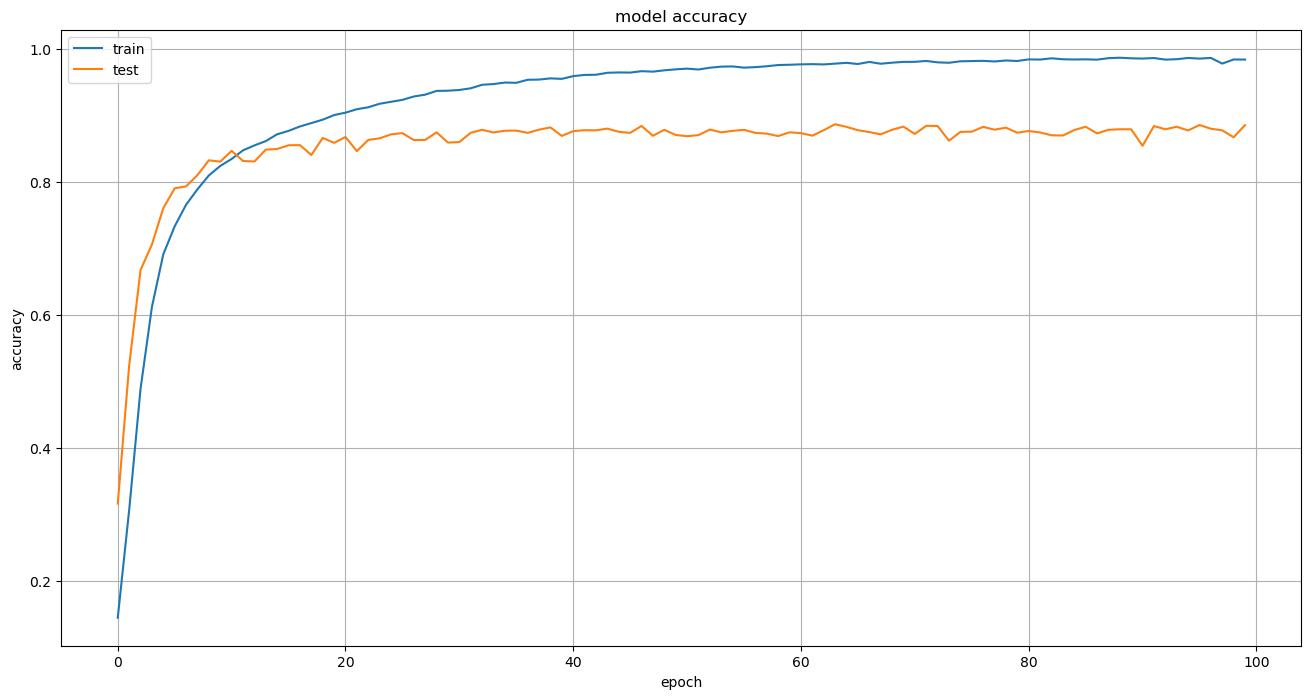

In [16]:
plothist(history)